## Algoritmo genético

In [54]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import random
from sympy import symbols, sympify, lambdify
import time
import copy


In [55]:
doc2 = open("C:/Users/antoc/Downloads/PortableGit/practica2024/hub_data.txt")
lineas2 = doc2.readlines()

H_0= 70

# Divide cada línea en columnas usando espacio como separador
datos_separados2 = [linea.strip().split(' ') for linea in lineas2]

datos= []
for fila in datos_separados2:
    datos.append(fila)

z = []
for i in range(len(datos)):
      a = float(datos[i][0])
      z.append(a)
z =np.array(z)

H = []
for i in range(len(datos)):
   if datos[i][1] == '':
      a = float(datos[i][2])
      H.append(a)
   else:
      a = float(datos[i][1])
      H.append(a)
H = np.array(H)

desv = []
for i in range(len(datos)):
    a = float(datos[i][2])
    desv.append(a)


Se minimiza $$\chi^2 = \sum_{i=1}^{N} (\dfrac{y_i - f(x_i)}{\sigma_{i}})^2$$ con el objetivo de obtener la función $f(x)$ que mejor se ajuste a los datos.


In [56]:
def polix(x):
    return x**x
def poli1(x):
    return (x+1) 
def poli2(x):
    return x**2
def poli3(x):
    return x**3
# Crear lista con coeficientes
coeficientes = [random.random() for i in range(5)]
# Crear lista de funciones
funciones_c = [lambda x, i=i: coeficientes[i] for i in range(5)]


grammar = [polix, poli1, poli2, poli3] + funciones_c
operaciones = ['+', '-', '*', '/']



#A partir de las funciones ingresadas inicialmente, calcula el chi_2
def chi_2_valores(f):
    return np.square((H - f(z))/desv)

def chi_2_f(f):
    chi_2_val = np.zeros_like(f)
    chi_2 = np.zeros_like(f)
    for i in range(len(f)):
        chi_2_val[i] = chi_2_valores(f[i])
        for j in range(len(chi_2_val)):
            chi_2[j] = np.sum(chi_2_val[j])
    
    return chi_2

#print(chi_2_f(grammar))
#chi_inic = chi_2_f(grammar)

### Combinar la función inicial
Se combinan las funciones iniciales con operaciones entre ellas hasta que haya una cantidad definida de funciones iniciales.
Se tomaron 50 funciones iniciales debido a que aumentará la cantidad de individuos a medida en que se realiza crossover y mutación a las funciones iniciales.

In [57]:
def juntar_elementos_inicial(funciones, operaciones, longitud_final=100):
    final = []
    while len(final) < longitud_final * 3:
        random_funcion1 = random.choice(funciones)
        random_funcion2 = random.choice(funciones)
        random_operador = random.choice(operaciones)

        final.append(random_funcion1)
        final.append(random_operador)
        final.append(random_funcion2)

    # Crear una lista de sublistas para representar las filas
    resultado_final_inicial = [final[i:i+3] for i in range(0, len(final), 3)]

    return resultado_final_inicial

resultado_final_inicial = juntar_elementos_inicial(grammar, operaciones)
#for fila in resultado_final_inicial:
#    print(fila)


### Convertir la lista a función
Se definen funciones para para convertir una lista de funciones y strings (operaciones) en una función.

In [58]:

#x deben estar entre paréntesis para no confundir con otros x en el string
def a_string(funcion):
    if funcion == polix:
        return '(x)**(x)'
    elif funcion == poli1:
        return '((x)+1)'
    elif funcion == poli2:
        return '(x)**2'
    elif funcion == poli3:
        return '(x)**3'
    for i in range(len(funciones_c)):
        if funcion == funciones_c[i]:
            return str(coeficientes[i])
    else:
        return str(funcion)

x = symbols('x')
def pasar_a_funcion(expresion):
    a_sympy = sympify(expresion)
    a_python = lambdify(x, a_sympy, 'numpy')
    return a_python

#print(pasar_a_funcion('exp(x**2)'))(2)
def composicion(lista):
    modi_int = a_string(lista[-1])
    #print(modi_int)
    for i in range(2,len(lista)+1):
        modi_ext = a_string(lista[-i])
        modi_int = modi_ext.replace('(x)', '('+ modi_int +')' )
    return modi_int


def convertir_lista_a_str(lista):
    string=''
    for i in range(len(lista)):
        if callable(lista[i]):
            if i != 0 and callable(lista[i - 1]):
                string = string
            elif i < len(lista) - 1 and callable(lista[i + 1]):
                compo = []
                for j in range(i, len(lista)):
                    if callable(lista[j]):
                        compo.append(lista[j])

                string += composicion(compo)
            
            else:  
                string += a_string(lista[i])
        else:
            string += lista[i]

    return string

#lista_prueba = [poli2, '+', poli1,'-',poli1, poli2, funciones_c[0] ,'-', poli1]
#funcion_prueba= convertir_lista_a_str(lista_prueba)
#print(funcion_prueba)

def convertir_lista_a_funcion(lista):
    string = convertir_lista_a_str(lista)
    func= pasar_a_funcion(string)
    return func

#print(convertir_lista_a_funcion(lista_prueba))


### Calcular los $\chi^2$ de la población inicial y seleccionar las mejores funciones

In [59]:
def mejores(resultado_final, tasa_seleccion = 0.2):
    chis =[]
    for fila in resultado_final:
        a = [convertir_lista_a_funcion(fila)]
        chi_combinaciones = chi_2_f(a)
        chis.append(chi_combinaciones)
    ''' 
    Se seleccionan elementos a combinar
    '''
    cant_sobrevivientes = tasa_seleccion*len(chis)
    cant_sobreviv = int(cant_sobrevivientes)
    #print('Cantidad de sobrevientes:' , cant_sobreviv)

    # Número de elementos más pequeños
    num_elementos = cant_sobreviv
    # Obtener los índices y valores de los elementos más pequeños en orden
    indices_valores_menores = sorted(enumerate(chis), key=lambda x: x[1])[:num_elementos]
    # Separar los índices y valores en listas distintas
    indices_menores, valores_menores = zip(*indices_valores_menores)

    f_mejores= []
    for numero in indices_menores:
        f_mejores.append(resultado_final[numero])

    return f_mejores, valores_menores


### Crossover
Combinar random partes de las soluciones de los padres (composición de funciones y sumar, multiplicar... una con otra).
La selección sirve para dejar pasar un cierto porcentaje, los cuales tendrán que acoplarse y mutar. O sea, el número baja con la selección pero aumenta con el crossover y mutación. Para cada elemento del crossover, salen 3 hijos que son producto de combinaciones con otros padres.

In [60]:
def a_combinar(padres, hijos_por_padre = 6):
    # Crear lista con 6 ecuaciones random a combinar
    combinar = [random.choice(padres) for i in range(hijos_por_padre)]

    # Separar funciones de operaciones para cada función que se combina con la seleccionada
    combinar_con = []
    for k in range(len(combinar)):
        funciones_combinar = []
        for j in range(len(combinar[k])):
            if callable(combinar[k][j]):  # Verificar si es una función
                funciones_combinar.append(combinar[k][j])

        #print(funciones_combinar)

        #Por cada ecuación se elige una función de la lista de funciones de esa ecuación
        combinar_con.append(random.choice(funciones_combinar)) #Elegir una función de las disponibles

    return combinar_con

#print(a_combinar(mejores(resultado_final_inicial)))


def crossover(padres, hijos_por_padre = 6):
    #El primer elemento se mantiene constante (mejor chi^2)
    hijos = []
    hijos.append(padres[0])
    for i in range(1, len(padres)):

        # Agregar operador y función combinada a cada hijo
        numero_random = [random.randint(0,1) for i in range(hijos_por_padre)]
        for k in range(len(numero_random)):
            hijos_ = copy.deepcopy(padres[i])
            #print(numero_random[k], k)
            if numero_random[k] == 0:
                random_operador = random.choice(operaciones)
                hijos_.append(random_operador)
                hijos_.append(a_combinar(padres, hijos_por_padre)[k])
            else:
                hijos_.append(a_combinar(padres, hijos_por_padre)[k])

            # Agregar los hijos a la lista final
            hijos.append(hijos_)

    #print(hijos)
    return hijos

### Mutación
tasa de mutación: 5, 10 %. Se cambia una parte random de las funciones

In [61]:
def mutar(padres, tasa_mutacion= 0.05):
    hijos = copy.deepcopy(padres)
    for lista in hijos:
        #Se deja constante 1 elemento
        for i in range(1, len(lista)):
            # Genera un número aleatorio entre 0 y 1
            probabilidad = random.random()

            # Verifica si el número aleatorio es menor que la probabilidad deseada
            if probabilidad < tasa_mutacion:
                if callable(lista[i]):
                    lista[i] = random.choice(grammar)
                else:
                    lista[i] = random.choice(operaciones)
    return hijos



### Recurrencia

In [62]:
chi_por_generaciones = []
def recurrencia(gener):
    poblacion_inicial = resultado_final_inicial

    # Medir el tiempo de ejecución de la función
    inicio_tiempo = time.time()  # Obtiene el tiempo actual

    # Mejores funciones de la población inicial
    mejores_inicial = mejores(poblacion_inicial)[0]

    generaciones =0
    while generaciones <= gener:
        #Contador de generaciones
        generaciones +=1
                
        # Obtener las mejores funciones de la población mejorada
        mejor_func_chi= mejores(mutar(crossover(mejores_inicial)))

        mejores_actual = mejor_func_chi[0]
        chi_mejores = mejor_func_chi[1]
        mejores_inicial = mejores_actual
        
        mejores_str = []
        for i in range(len(mejores_actual)):
            mejores_str.append(convertir_lista_a_str(mejores_actual[i]))

        if len(mejores_str)>= 500:
            mejores_actual = mejores_actual[:50]
            mejores_inicial = mejores_actual

        print(f"Mejores funciones en esta iteración: {mejores_str}")
        print(f"Largo mejores funciones en esta iteración: {len(mejores_str)}")
        print(f"generación: {generaciones}")
        #print(f"Chi^2: {chi_mejores}")
        
        #Se suma a una lista el mejor chi para cada generación
        chi_por_generaciones.append(chi_mejores[0][0])
        #print(f"Chi^2 por generación: {chi_por_generaciones}")

    fin_tiempo = time.time()  # Obtiene el tiempo después de la ejecución

    tiempo_total = fin_tiempo - inicio_tiempo
    print(f"El tiempo de ejecución fue: {tiempo_total} segundos")

    return mejores_str, chi_por_generaciones

generaciones_evaluar = 20
recu = recurrencia(generaciones_evaluar)


Mejores funciones en esta iteración: ['0.35359812827505/0.013745380175946953/0.35359812827505', '((x)+1)+0.8179589291464675/0.013745380175946953', '0.6897221107274952/0.013745380175946953', '0.35359812827505/0.013745380175946953/(x)**(x)', '0.35359812827505/0.013745380175946953+(x)**(x)', '0.3389133795809527/0.013745380175946953+((x)+1)', '0.35359812827505/0.013745380175946953', '0.35359812827505/0.013745380175946953', '0.3389133795809527/0.013745380175946953', '0.3389133795809527/0.013745380175946953', '0.3389133795809527/0.013745380175946953', '0.3389133795809527/0.013745380175946953', '0.3389133795809527/0.013745380175946953', '((x)+1)/(0.3389133795809527)**2', '(x)**(x)/0.35359812827505*(x)**(x)', '(x)**3*(x)**(x)/0.3389133795809527', '((x)+1)*(x)**3*((x)+1)', '(x)**3*(x)**3-0.6897221107274952', '(x)**2/0.3389133795809527*(x)**(x)', '(x)**3*(x)**3-((x)+1)', '(x)**3*(x)**(x)+0.6897221107274952', '(x)**(x)/(x)**2+(x)**3', '(x)**(x)/(x)**2*((x)+1)']
Largo mejores funciones en esta ite

<lambdifygenerated-36720>:2: RuntimeWarning: overflow encountered in power
  return (x**3 + 59.507916018053412*x + x**x + 61.017761502641627 + 0.00013031297542308131*(x**6)**(x**6)/x**3)


Mejores funciones en esta iteración: ['((x)+1)*0.8179589291464675/0.013745380175946953+(x)**(x)-0.013745380175946953*0.6897221107274952*0.3389133795809527+(x)**3+((((((0.8179589291464675)**2)**((0.8179589291464675)**2))+1))+1)*((0.8179589291464675)**2)**((0.8179589291464675)**2)/((x)+1)/(((x)**2)+1)', '((x)+1)*0.8179589291464675/0.013745380175946953+0.3389133795809527-0.3389133795809527-0.8179589291464675+0.8179589291464675+(x)**(x)/0.35359812827505-((x)+1)-0.013745380175946953+(x)**(x)+0.6897221107274952+0.013745380175946953', '((x)+1)*0.8179589291464675/0.013745380175946953+0.3389133795809527-0.3389133795809527-0.8179589291464675+0.8179589291464675+(x)**(x)/0.35359812827505-((x)+1)+0.013745380175946953+(x)**(x)+0.6897221107274952', '((x)+1)*0.8179589291464675/0.013745380175946953+0.3389133795809527-0.3389133795809527-0.8179589291464675+0.8179589291464675+(x)**(x)/0.35359812827505-((x)+1)+0.013745380175946953+(x)**(x)+0.6897221107274952', '((x)+1)*0.8179589291464675/0.0137453801759469

<lambdifygenerated-38167>:2: RuntimeWarning: overflow encountered in power
  return (59.507916018053412*x + 3.222392375244806*x**x - 0.8179589291464675*(x + 1)**(-x - 1)*(((x + 1)**(x + 1))**((x + 1)**(x + 1)))**(((x + 1)**(x + 1))**((x + 1)**(x + 1))) + 58.54097668229047)
<lambdifygenerated-39634>:2: RuntimeWarning: overflow encountered in power
  return (2.156800722126599*x**3 + 59.507916018053412*x - x**x*(x + 1) + x**x + 0.00013031297542308131*((x + 1)**(2*x + 2))**((x + 1)**(2*x + 2)) + 60.197638128780907)
<ipython-input-56-071764feebb4>:22: RuntimeWarning: overflow encountered in square
  return np.square((H - f(z))/desv)


Mejores funciones en esta iteración: ['((x)+1)*0.8179589291464675/0.013745380175946953+0.6897221107274952-0.6897221107274952+(x)**(x)+(x)**(x)*((0.8179589291464675)+1)+(x)**2*0.6897221107274952*0.35359812827505/(x)**3', '((x)+1)*0.8179589291464675/0.013745380175946953+(x)**(x)-0.013745380175946953*0.6897221107274952-0.35359812827505+(x)**3+((((0.8179589291464675)+1))+1)*0.8179589291464675*0.6897221107274952+0.013745380175946953/(x)**2', '((x)+1)*0.8179589291464675/0.013745380175946953+(x)**(x)-0.013745380175946953*0.6897221107274952-0.35359812827505+(x)**3-0.013745380175946953-0.013745380175946953+0.8179589291464675+(((0.35359812827505)+1))**(((0.35359812827505)+1))/((x)+1)*(x)**(x)/0.6897221107274952', '((x)+1)*0.8179589291464675/0.013745380175946953+0.3389133795809527-0.3389133795809527-0.8179589291464675+0.8179589291464675+(x)**(x)/0.35359812827505-((x)+1)-0.013745380175946953+(x)**(x)+0.6897221107274952+0.013745380175946953', '((x)+1)*0.8179589291464675/0.013745380175946953+0.33891

<lambdifygenerated-42628>:2: RuntimeWarning: overflow encountered in power
  return (x**3 + 59.507916018053412*x - x**x*((x**x)**(x**x))**((x**x)**(x**x)) + x**x + 59.997246827933469)
<lambdifygenerated-43142>:2: RuntimeWarning: overflow encountered in power
  return (59.507916018053412*x + 2.222392375244806*x**x - ((((x**x)**(x**x))**((x**x)**(x**x)) + 1)**2)**((((x**x)**(x**x))**((x**x)**(x**x)) + 1)**2) + 60.192979635531852)
<lambdifygenerated-43939>:2: RuntimeWarning: overflow encountered in power
  return (0.6897221107274952*x**2 + 59.507916018053412*x + 2.817958929146468*x**x - 0.013745380175946953*((x**3 + 1)**(x**3 + 1))**((x**3 + 1)**(x**3 + 1)) + 59.521661398229359)


Mejores funciones en esta iteración: ['((x)+1)*0.8179589291464675/0.013745380175946953+(x)**(x)-(0.013745380175946953)**2*0.6897221107274952*0.35359812827505+(x)**3+((((0.8179589291464675)+1))+1)*0.8179589291464675/((x)+1)-0.35359812827505*(0.013745380175946953)**2+0.013745380175946953+0.013745380175946953/(x)**2', '((x)+1)*0.8179589291464675/0.013745380175946953+(x)**(x)-0.013745380175946953+0.6897221107274952*0.3389133795809527+(x)**3+(((((0.8179589291464675)**2)**((0.8179589291464675)**2))+1))**2*((0.8179589291464675)**2)**((0.8179589291464675)**2)/((x)+1)*0.8179589291464675-0.35359812827505/((x)**2)**((x)**2)', '((x)+1)*0.8179589291464675/0.013745380175946953+(x)**(x)-0.013745380175946953*0.6897221107274952-0.35359812827505+(x)**3-0.013745380175946953-0.013745380175946953+0.8179589291464675+(((0.35359812827505)+1))**(((0.35359812827505)+1))/((x)+1)*(x)**(x)/0.6897221107274952-0.8179589291464675', '((x)+1)*0.8179589291464675/0.013745380175946953+(x)**(x)-0.013745380175946953*0.68972

['((x)+1)*0.8179589291464675/0.013745380175946953+(x)**3-0.8179589291464675*0.8179589291464675-0.35359812827505+(x)**3+((((0.8179589291464675)+1))+1)/0.8179589291464675/((x)+1)+0.6897221107274952-0.3389133795809527*0.6897221107274952', '((x)+1)*0.8179589291464675/0.013745380175946953+(x)**(x)-0.013745380175946953*0.6897221107274952-0.35359812827505+(x)**3-0.013745380175946953-0.013745380175946953+0.8179589291464675+(((0.35359812827505)+1))**(((0.35359812827505)+1))/((x)+1)*(x)**(x)/0.6897221107274952/((x)+1)', '((x)+1)*0.8179589291464675/0.013745380175946953+(x)**(x)-0.013745380175946953+0.6897221107274952*0.3389133795809527+(x)**3+(((((0.8179589291464675)**2)**((0.8179589291464675)**2))+1))**2*((0.8179589291464675)**2)**((0.8179589291464675)**2)/((x)+1)*0.8179589291464675-0.35359812827505/(((x)**2)**2)**(((x)**2)**2)', '((x)+1)*0.8179589291464675/0.013745380175946953+(x)**(x)-0.013745380175946953*0.6897221107274952-0.35359812827505+(x)**3-0.013745380175946953-0.013745380175946953+0.81

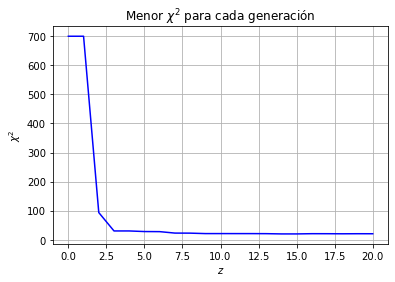

In [63]:
funciones_finales = recu[0]
chis_finales = recu[1]
print(funciones_finales)
print(f"Menor chi^2: {recu[1][-1]}")
#print(recu[1])

z_chis= np.linspace(0, generaciones_evaluar, generaciones_evaluar + 1)
plt.xlabel('$ z $')
plt.ylabel('$ \chi^2 $')
plt.title('Menor $\chi^2$ para cada generación')
plt.plot(z_chis,chis_finales, color = 'blue')
plt.grid(True)
plt.show()

In [64]:
#Graficando la función teórica

#Parámetros
omega_r = 8.4e-5
omega_l = 0.7 - omega_r
omega_0 = 1
omega_k = 1 - omega_0

omega_m = 1 - omega_k - omega_l - omega_r

#Creamos la función teórica
array_z = np.array(z)

def H_t(z):
    return H_0* ((omega_r * (1+z)**4) + omega_m * (1+z)**3 + omega_l + omega_k* (1+z)**2)**(1/2)

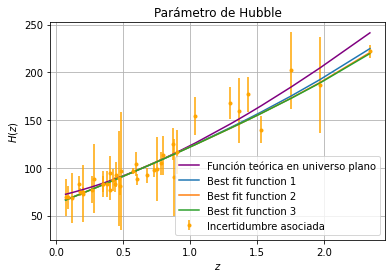

In [65]:
best_fit = []
for string in funciones_finales:
    a= pasar_a_funcion(string)
    best_fit.append(a)

yerr = desv
plt.xlabel('$ z $')
plt.ylabel('$ H(z) $')
plt.title('Parámetro de Hubble')

omega_0 = 1
omega_k = 1 - omega_0
plt.plot(array_z, H_t(array_z), color = 'purple', label='Función teórica en universo plano')
plt.plot(z, best_fit[0](z), label= 'Best fit function 1')
plt.plot(z, best_fit[1](z), label= 'Best fit function 2')
plt.plot(z, best_fit[2](z), label= 'Best fit function 3')
#plt.plot(z, best_fit[3](z), label= 'Best fit function 4')

plt.errorbar(z, H, yerr=yerr, fmt='.', color = 'orange', label = 'Incertidumbre asociada')
plt.legend()
plt.grid(True)
plt.show()


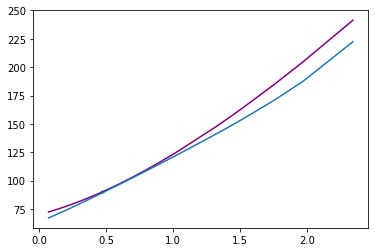

In [66]:
def mejor_fit(x):
    return 3.177+(x+1)*57.906+((x**x)/0.258)-(x+1/(x**x))

plt.plot(array_z, H_t(array_z), color = 'purple', label='Función teórica en universo plano')
plt.plot(z, mejor_fit(z), label= 'Best fit function 1')